# ArangoDB NetworkX Adapter Getting Started Guide  

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/master/examples/ArangoDB_NetworkX_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://github.com/arangoml/networkx-adapter/blob/master/examples/assets/logos/ArangoDB_logo.png?raw=1)
![networkX](https://github.com/arangoml/networkx-adapter/blob/master/examples/assets/logos/networkx_logo.svg?raw=1) 

Version: 3.0.1

Objective: Export Graphs from [ArangoDB](https://www.arangodb.com/), a multi-model Graph Database, to [NetworkX](https://networkx.github.io/), the swiss army knife for graph analysis in python, and vice-versa.

# Setup

In [1]:
%%capture
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!git clone -b 3.0.1 --single-branch https://github.com/arangoml/networkx-adapter.git
!rsync -av interactive_tutorials/ ./ --exclude=.git
!pip3 install adbnx_adapter==3.0.1
!pip3 install matplotlib
!pip3 install pyArango

In [2]:
import json
import oasis
import matplotlib.pyplot as plt

import networkx as nx

from adbnx_adapter.adapter import ADBNX_Adapter
from adbnx_adapter.controller import ADBNX_Controller
from adbnx_adapter.typings import Json, ArangoMetagraph, NxId, NxData

# Understanding NetworkX

(referenced from [networkx.org/documentation](https://networkx.org/documentation/stable/reference/index.html))

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. It provides:
* tools for the study of the structure and dynamics of social, biological, and infrastructure networks;
* a standard programming interface and graph implementation that is suitable for many applications;
* a rapid development environment for collaborative, multidisciplinary projects;
* an interface to existing numerical algorithms and code written in C, C++, and FORTRAN; and
* the ability to painlessly work with large nonstandard data sets.

With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more.


The following basic graph types are provided as Python classes:

`Graph`
* This class implements an undirected graph. It ignores multiple edges between two nodes. It does allow self-loop edges between a node and itself.

`DiGraph`
* Directed graphs, that is, graphs with directed edges. Provides operations common to directed graphs, (a subclass of Graph).

`MultiGraph`
* A flexible graph class that allows multiple undirected edges between pairs of nodes. The additional flexibility leads to some degradation in performance, though usually not significant.

`MultiDiGraph`
A directed version of a MultiGraph.

**Note: To maximize NetworkX usability, the ArangoDB-NetworkX Adapter creates NetworkX graphs of type `MultiDiGraph`. You can to the NetworkX documentation for converting a `MultiDiGraph` to other types.**


However, for now, let's take a look at creating a regular `Graph`:

In [3]:
import networkx as nx
G = nx.Graph()
G.add_edge(1, 2)  # default edge data=1
G.add_edge(2, 3, weight=0.9)  # specify edge data

Edge attributes can be anything:

In [4]:
import math
G.add_edge('y', 'x', function=math.cos)
G.add_node(math.cos)  # any hashable can be a node

You can add many edges at one time:

In [5]:
elist = [(1, 2), (2, 3), (1, 4), (4, 2)]
G.add_edges_from(elist)
elist = [('a', 'b', 5.0), ('b', 'c', 3.0), ('a', 'c', 1.0), ('c', 'd', 7.3)]
G.add_weighted_edges_from(elist)

### Algorithms

A number of graph algorithms are provided with NetworkX. These include shortest path, and breadth first search, clustering and isomorphism algorithms and others.

As an example here is code to use Dijkstra’s algorithm to find the shortest weighted path:

In [6]:
G = nx.Graph()
e = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]
G.add_weighted_edges_from(e)
print(nx.dijkstra_path(G, 'a', 'd'))

['a', 'c', 'd']


### Drawing

While NetworkX is not designed as a network drawing tool, we provide a simple interface to drawing packages and some simple layout algorithms.

The basic drawing functions essentially place the nodes on a scatterplot using the positions you provide via a dictionary or the positions are computed with a layout function. The edges are lines between those dots:

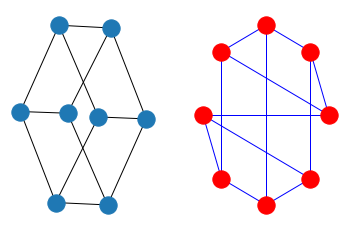

In [7]:
import matplotlib.pyplot as plt
G = nx.cubical_graph()
subax1 = plt.subplot(121)
nx.draw(G)   # default spring_layout
subax2 = plt.subplot(122)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

### Data Structure

NetworkX uses a “dictionary of dictionaries of dictionaries” as the basic network data structure. This allows fast lookup with reasonable storage for large sparse networks. The keys are nodes so G[u] returns an adjacency dictionary keyed by neighbor to the edge attribute dictionary. A view of the adjacency data structure is provided by the dict-like object G.adj as e.g. for node, nbrsdict in G.adj.items():. The expression G[u][v] returns the edge attribute dictionary itself. A dictionary of lists would have also been possible, but not allow fast edge detection nor convenient storage of edge data.

As an example, here is a representation of an undirected graph with the edges 

In [8]:
G = nx.Graph()
G.add_edge('A', 'B')
G.add_edge('B', 'C')
print(G.adj)

{'A': {'B': {}}, 'B': {'A': {}, 'C': {}}, 'C': {'B': {}}}


Graphs provide two interfaces to the edge data attributes: adjacency and edges. So G[u][v]['width'] is the same as G.edges[u, v]['width'].

In [9]:
G = nx.Graph()
G.add_edge(1, 2, color='red', weight=0.84, size=300)
print(G[1][2]['size'])
print(G.edges[1, 2]['color'])

300
red


# Create a Temporary ArangoDB Oasis Instance

In [10]:
# Request temporary instance from the managed ArangoDB Cloud Oasis.
con = oasis.getTempCredentials()

# Connect to the db via the python-arango driver
db = oasis.connect_python_arango(con)

print('\n--------------------')
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')

Requesting new temp credentials.
Temp database ready to use.

--------------------
https://tutorials.arangodb.cloud:8529
Username: TUT95b328zdyqvu6icc2szy7l
Password: TUTqy7aejhetdpkpplf7nwbai
Database: TUTl7w91pj995boxn9f4etz6
--------------------



Feel free to use to above URL to checkout the UI!

# Data Import

For demo purposes, we will be using the [ArangoDB Fraud Detection example graph](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Fraud_Detection.ipynb), and the [ArangoDB IMDB Dataset](https://github.com/arangodb/example-datasets/tree/master/Graphs/IMDB).

In [11]:
%%capture
!chmod -R 755 ./tools
!./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "networkx-adapter/examples/data/fraud_dump" --include-system-collections true
!./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --replication-factor 3  --input-directory "networkx-adapter/examples/data/imdb_dump" --include-system-collections true

# Instantiate the Adapter

Connect the ArangoDB-Networkx Adapter to our temporary ArangoDB cluster:

In [12]:
adbnx_adapter = ADBNX_Adapter(con)

Connecting to https://tutorials.arangodb.cloud:8529


# ArangoDB to NetworkX



## Via ArangoDB Graph

Data source
* ArangoDB Fraud-Detection Graph

Package methods used
* [`adbnx_adapter.adapter.arangodb_graph_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L160-L179)

Important notes
* The `name` parameter in this case must point to an existing ArangoDB graph in your ArangoDB instance. 


NetworkX: fraud-detection created

--------------------
MultiDiGraph named 'fraud-detection' with 71 nodes and 116 edges
[('account/10000011', {'_key': '10000011', '_id': 'account/10000011', '_rev': '_dfEQim----', 'Balance': 5331, 'Status': 'active', 'account_opening_date': '2018-3-13', 'account_type': 'checking', 'bank_id': 10000000001, 'branch_id': 10001, 'customer_id': 10000009, 'rank': 0.0021126761566847563}), ('account/10000016', {'_key': '10000016', '_id': 'account/10000016', '_rev': '_dfEQim---_', 'Balance': 7630, 'Status': 'active', 'account_opening_date': '2018-10-15', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10005, 'customer_id': 10000004, 'rank': 0.003122549969702959}), ('account/10000003', {'_key': '10000003', '_id': 'account/10000003', '_rev': '_dfEQim---A', 'Balance': 1433, 'Status': 'active', 'account_opening_date': '2017-10-24', 'account_type': 'checking', 'bank_id': 10000000002, 'branch_id': 10006, 'customer_id': 10000004, 'rank': 0.005249713547

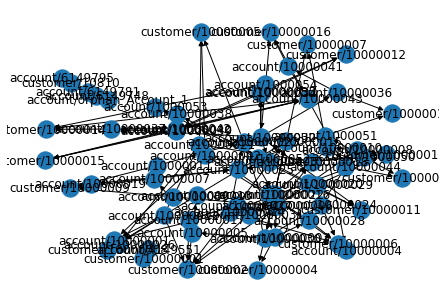

In [13]:
# Define graph name
graph_name = "fraud-detection"

# Create NetworkX graph from ArangoDB graph
nx_g = adbnx_adapter.arangodb_graph_to_networkx(graph_name)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_graph_to_networkx(graph_name, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))
nx.draw(nx_g, with_labels=True)

## Via ArangoDB Collections

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbnx_adapter.adapter.arangodb_collections_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L130-L158)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `vertex_collections` & `edge_collections` parameters must point to existing ArangoDB collections within your ArangoDB instance.

NetworkX: fraud-detection created

--------------------
MultiDiGraph named 'fraud-detection' with 88 nodes and 120 edges
[('branch/1548210', {'_key': '1548210', '_id': 'branch/1548210', '_rev': '_dfEQik2---', 'City': 'Austin', 'Country': 'US', 'Id': 10008, 'Postcode': 78704, 'bank_id': 10000000003, 'branch_id': 10008, 'branch_name': 'Bank Three Austin ', 'street_name': 'Bouldin Ave'}), ('branch/1548212', {'_key': '1548212', '_id': 'branch/1548212', '_rev': '_dfEQik2--_', 'City': 'Boston', 'Country': 'US', 'Id': 10010, 'Postcode': 2101, 'bank_id': 10000000003, 'branch_id': 10010, 'branch_name': 'Bank Three Boston', 'street_name': 'Kendall Square'}), ('branch/1548204', {'_key': '1548204', '_id': 'branch/1548204', '_rev': '_dfEQik2--A', 'City': 'Austin', 'Country': 'US', 'Id': 10002, 'Postcode': 78704, 'bank_id': 10000000001, 'branch_id': 10002, 'branch_name': 'Bank One Austin ', 'street_name': 'Bouldin Ave'}), ('branch/1548203', {'_key': '1548203', '_id': 'branch/1548203', '_rev': '_dfEQ

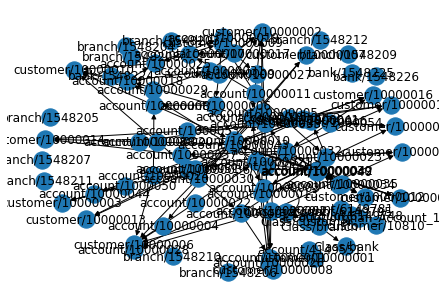

In [14]:
# Define collection
vertex_collections = {"account", "bank", "branch", "Class", "customer"}
edge_collections = {"accountHolder", "Relationship", "transaction"}

# Create NetworkX graph from ArangoDB collections
nx_g = adbnx_adapter.arangodb_collections_to_networkx("fraud-detection", vertex_collections, edge_collections)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_collections_to_networkx("fraud-detection", vertex_collections, edge_collections, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))
nx.draw(nx_g, with_labels=True)

## Via ArangoDB Metagraph

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbnx_adapter.adapter.arangodb_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L55-L128)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.

NetworkX: fraud-detection created

--------------------
MultiDiGraph named 'fraud-detection' with 88 nodes and 120 edges
[('account/10000011', {'Balance': 5331, '_id': 'account/10000011', 'account_type': 'checking', 'customer_id': 10000009, 'rank': 0.0021126761566847563}), ('account/10000016', {'Balance': 7630, '_id': 'account/10000016', 'account_type': 'checking', 'customer_id': 10000004, 'rank': 0.003122549969702959}), ('account/10000003', {'Balance': 1433, '_id': 'account/10000003', 'account_type': 'checking', 'customer_id': 10000004, 'rank': 0.00524971354752779}), ('account/10000029', {'Balance': 2201, '_id': 'account/10000029', 'account_type': 'checking', 'customer_id': 10000010, 'rank': 0.0021126761566847563}), ('account/10000005', {'Balance': 4837, '_id': 'account/10000005', 'account_type': 'checking', 'customer_id': 10000002, 'rank': 0.004550427198410034}), ('account/10000032', {'Balance': 5817, '_id': 'account/10000032', 'account_type': 'checking', 'customer_id': 10000011, 'ra

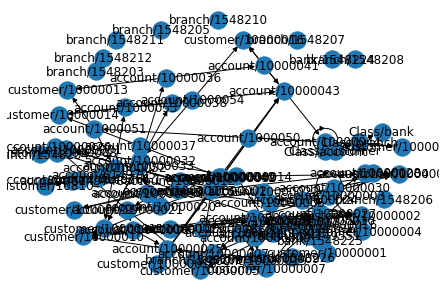

In [15]:
# Define metagraph
fraud_detection_metagraph = {
    "vertexCollections": {
        "account": {"Balance", "account_type", "customer_id", "rank"},
        "bank": {"Country", "Id", "bank_id", "bank_name"},
        "branch": {"City", "Country", "Id", "bank_id", "branch_id", "branch_name"},
        "Class": {"concrete", "label", "name"},
        "customer": {"Name", "Sex", "Ssn", "rank"},
    },
    "edgeCollections": {
        "accountHolder": {},
        "Relationship": {"label", "name", "relationshipType"},
        "transaction": {"transaction_amt", "sender_bank_id", "receiver_bank_id"},
    },
}

# Create NetworkX Graph from attributes
nx_g = adbnx_adapter.arangodb_to_networkx('fraud-detection',  fraud_detection_metagraph)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = adbnx_adapter.arangodb_to_networkx('fraud-detection',  fraud_detection_metagraph, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))

nx.draw(nx_g, with_labels=True)

## Via ArangoDB Metagraph with a custom controller

Data source
* ArangoDB Fraud-Detection Collections

Package methods used
* [`adbnx_adapter.adapter.arangodb_to_networkx()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L55-L128)
* [`adbnx_adapter.controller._prepare_arangodb_vertex()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/controller.py#L20-L36)

Important notes
* The `name` parameter in this case is simply for naming your NetworkX graph.
* The `metagraph` parameter should contain collections & associated document attributes names that exist within your ArangoDB instance.
* We are creating a custom `ADBNX_Controller` to specify *how* to convert our ArangoDB vertices into NetworkX nodes. View the default `ADBNX_Controller` [here](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/controller.py#L10).

In [16]:
# Define metagraph
imdb_metagraph = {
    "vertexCollections": {"Users": {"Age", "Gender"}, "Movies": {}},
    "edgeCollections": {"Ratings": {"Rating"}},
}

class IMDB_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.

    You can derive your own custom ADBNX_Controller, but it is not
    necessary for Homogeneous graphs.
    """
    # We re-define how vertex pre-insertion should be treated, specifically for the IMDB dataset.
    def _prepare_arangodb_vertex(self, adb_vertex: Json, col: str) -> NxId:
        """Prepare an ArangoDB vertex before it gets inserted into the NetworkX
        graph.

        Given an ArangoDB vertex, you can modify it before it gets inserted
        into the NetworkX graph, and/or derive a custom node id for networkx to use.
        In most cases, it is only required to return the ArangoDB _id of the vertex.

        :param vertex: The ArangoDB vertex object to (optionally) modify.
        :type vertex: adbnx_adapter.typings.Json
        :param col: The ArangoDB collection the vertex belongs to.
        :type col: str
        :return: The ArangoDB _id attribute of the vertex.
        :rtype: str
        """
        adb_vertex["bipartite"] = 0 if col == "Users" else 1 # New bipartite attribute logic
        return super()._prepare_arangodb_vertex(adb_vertex, col) # Return ArangoDB _id

    # We're not interested in re-defining pre-insertion handling for edges, so we leave it alone
    # def _prepare_arangodb_edge(self, adb_edge: Json, col: str) -> NxId:
    #   return super()._prepare_arangodb_edge(edge, collection)

# Instantiate the custom adapter
imdb_adbnx_adapter = ADBNX_Adapter(con, IMDB_ADBNX_Controller())

# Create NetworkX Graph from metagraph using the custom IMDB_ArangoDB_Networx_Adapter
nx_g = imdb_adbnx_adapter.arangodb_to_networkx("IMDBGraph", imdb_metagraph)

# You can also provide valid Python-Arango AQL query options to the command above, like such:
# nx_g = imdb_adbnx_adapter.arangodb_to_networkx("IMDBGraph", imdb_metagraph, ttl=1000, stream=True)
# See more here: https://docs.python-arango.com/en/main/specs.html#arango.aql.AQL.execute

# Show graph data
print('\n--------------------')
print(nx_g)
print(nx_g.nodes(data=True))
# print(nx_g.edges(data=True)) # (will exceed IOPub data rate)
# nx.draw(nx_g, with_labels=True) # (will exceed IOPub data rate)

Connecting to https://tutorials.arangodb.cloud:8529
NetworkX: IMDBGraph created

--------------------
MultiDiGraph named 'IMDBGraph' with 2625 nodes and 65499 edges
[('Users/1', {'Age': 35, 'Gender': 'M', '_id': 'Users/1', 'bipartite': 0}), ('Users/2', {'Age': 53, 'Gender': 'F', '_id': 'Users/2', 'bipartite': 0}), ('Users/3', {'Age': 23, 'Gender': 'M', '_id': 'Users/3', 'bipartite': 0}), ('Users/4', {'Age': 24, 'Gender': 'M', '_id': 'Users/4', 'bipartite': 0}), ('Users/5', {'Age': 33, 'Gender': 'F', '_id': 'Users/5', 'bipartite': 0}), ('Users/6', {'Age': 42, 'Gender': 'M', '_id': 'Users/6', 'bipartite': 0}), ('Users/7', {'Age': 57, 'Gender': 'M', '_id': 'Users/7', 'bipartite': 0}), ('Users/8', {'Age': 36, 'Gender': 'M', '_id': 'Users/8', 'bipartite': 0}), ('Users/9', {'Age': 29, 'Gender': 'M', '_id': 'Users/9', 'bipartite': 0}), ('Users/10', {'Age': 53, 'Gender': 'M', '_id': 'Users/10', 'bipartite': 0}), ('Users/11', {'Age': 39, 'Gender': 'F', '_id': 'Users/11', 'bipartite': 0}), ('Use

# NetworkX to ArangoDB

## Example 1: NetworkX Grid Graph

Data source
* [NetworkX Grid Graph](https://networkx.org/documentation/stable/auto_examples/basic/plot_read_write.html#sphx-glr-auto-examples-basic-plot-read-write-py)

Package methods used
* [`adbnx_adapter.adapter.networkx_to_arangodb()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L181-L311)

Important notes
* The `name` parameter in this case is simply for naming your ArangoDB graph.
* The `edge_definitions` parameter should contain a list of valid vertex relationships along with their related edge collections. See its [official documentation](https://docs.python-arango.com/en/main/graph.html#edge-definitions) for more details.
* We are using a `batch_size` value of 1 to demo to users that this feature exists. It is not recommended to use a `batch_size` value of 1 in a real setting.

ArangoDB: Grid_1 created

--------------------
https://tutorials.arangodb.cloud:8529
Username: TUT95b328zdyqvu6icc2szy7l
Password: TUTqy7aejhetdpkpplf7nwbai
Database: TUTl7w91pj995boxn9f4etz6
--------------------

Inspect the graph here: https://tutorials.arangodb.cloud:8529/_db/TUTl7w91pj995boxn9f4etz6/_admin/aardvark/index.html#graph/Grid_1
View the original graph here: https://networkx.org/documentation/stable/auto_examples/basic/plot_read_write.html#sphx-glr-auto-examples-basic-plot-read-write-py)


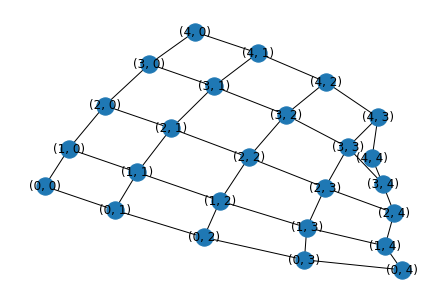

In [17]:
# Load the nx graph & draw
grid_nx_g = nx.grid_2d_graph(5, 5)
nx.draw(grid_nx_g, with_labels=True)

# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Homogeneous, we only need one edge definition.
edge_definitions = [
    {
        "edge_collection": "to",
        "from_vertex_collections": ["Grid_Node"],
        "to_vertex_collections": ["Grid_Node"],
    }
]

# Create the ArangoDB graph
name = "Grid_1"
db.delete_graph(name, drop_collections=True, ignore_missing=True)
grid_adb_g = adbnx_adapter.networkx_to_arangodb(name, grid_nx_g, edge_definitions, batch_size=1)

print('\n--------------------')
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"Inspect the graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")
print(f"View the original graph here: https://networkx.org/documentation/stable/auto_examples/basic/plot_read_write.html#sphx-glr-auto-examples-basic-plot-read-write-py)")

## Example 2: NetworkX Football Graph

Data source
* [NetworkX Football Graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_football.html)

Package methods used
* [`adbnx_adapter.adapter.networkx_to_arangodb()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/adapter.py#L181-L311)
* [`adbnx_adapter.controller._keyify_networkx_node()`](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/controller.py#L101-L121)

Important notes
* The `name` parameter in this case is simply for naming your ArangoDB graph.
* The `edge_definitions` parameter should contain a list of valid vertex relationships along with their related edge collections. See its [official documentation](https://docs.python-arango.com/en/main/graph.html#edge-definitions) for more details.
* We are creating a custom `ADBNX_Controller` to specify *how* to convert our NetworkX nodes into ArangoDB vertices. View the default `ADBNX_Controller` [here](https://github.com/arangoml/networkx-adapter/blob/3.0.0/adbnx_adapter/controller.py#L10).
    * This is a unique case where the node IDs of the NetworkX Football graphs are of type string. We need to make sure that these string **do not** contain any [invalid characters](https://www.arangodb.com/docs/stable/data-modeling-naming-conventions-document-keys.html), so we use a built-in helper method.

Connecting to https://tutorials.arangodb.cloud:8529
ArangoDB: Football created

--------------------
https://tutorials.arangodb.cloud:8529
Username: TUT95b328zdyqvu6icc2szy7l
Password: TUTqy7aejhetdpkpplf7nwbai
Database: TUTl7w91pj995boxn9f4etz6
--------------------

Inspect the graph here: https://tutorials.arangodb.cloud:8529/_db/TUTl7w91pj995boxn9f4etz6/_admin/aardvark/index.html#graph/Football
View the original graph here: https://networkx.org/documentation/stable/auto_examples/graph/plot_football.html#sphx-glr-auto-examples-graph-plot-football-py)


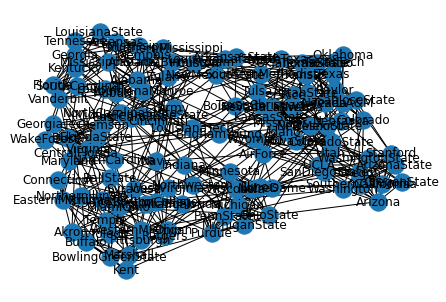

In [18]:
import io
import zipfile
import urllib.request as urllib

def get_football_graph():
    url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"
    sock = urllib.urlopen(url)
    s = io.BytesIO(sock.read())
    sock.close()
    zf = zipfile.ZipFile(s)
    gml = zf.read("football.gml").decode()
    gml_list = gml.split("\n")[1:]
    return nx.parse_gml(gml_list)

football_nx_g = get_football_graph()
nx.draw(football_nx_g, with_labels=True)

# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Homogeneous, we only need one edge definition.
edge_definitions = [
    {
        "edge_collection": "played",
        "from_vertex_collections": ["Football_Team"],
        "to_vertex_collections": ["Football_Team"],
    }
]

class Football_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.

    You can derive your own custom ADBNX_Controller, but it is not
    necessary for Homogeneous graphs.
    """
    def _keyify_networkx_node(self, nx_node_id: NxId, nx_node: NxData, col: str) -> str:
        """Given a NetworkX node, derive its valid ArangoDB key.

        NOTE: You must override this function if you want to create custom ArangoDB _key
        values for your NetworkX nodes or if your NetworkX graph does NOT comply to
        ArangoDB standards (i.e the node IDs are not formatted
        like "{collection}/{key}"). For more  info, see the **keyify_nodes**
        parameter of ADBNX_Adapter.networkx_to_arangodb()

        :param nx_node: The NetworkX node object.
        :type nx_node: dict
        :param col: The ArangoDB collection the node belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        # Since our NetworkX Football nodes have an id of type string, we can use the existing helper function.
        adb_v_key: str = self._string_to_arangodb_key_helper(str(nx_node_id))
        return adb_v_key

# Instantiate the adapter
football_adbnx_adapter = ADBNX_Adapter(con, Football_ADBNX_Controller())

# Create the ArangoDB graph
name = "Football"
db.delete_graph(name, drop_collections=True, ignore_missing=True)
football_adb_g = football_adbnx_adapter.networkx_to_arangodb(name, football_nx_g, edge_definitions, keyify_nodes=True)

print('\n--------------------')
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])
print('--------------------\n')
print(f"Inspect the graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")
print(f"View the original graph here: https://networkx.org/documentation/stable/auto_examples/graph/plot_football.html#sphx-glr-auto-examples-graph-plot-football-py)")

# Full Cycles

## Example 1: ArangoDB ➡ NetworkX ➡ ArangoDB (with existing collections)

NetworkX: fraud-detection created
ArangoDB: fraud-detection created
Inspect the overwritten graph here: https://tutorials.arangodb.cloud:8529/_db/TUTl7w91pj995boxn9f4etz6/_admin/aardvark/index.html#graph/fraud-detection


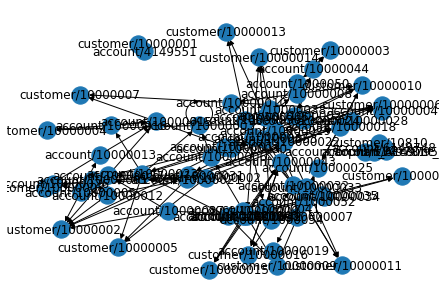

In [19]:
name = "fraud-detection"

# Start from ArangoDB graph
original_fraud_adb_g = db.graph(name)
edge_definitions = original_fraud_adb_g.edge_definitions()

# Create NetworkX graph from ArangoDB graph
fraud_nx_g = adbnx_adapter.arangodb_graph_to_networkx(name)
nx.draw(fraud_nx_g, with_labels=True)

# Modify the NetworkX graph
for _, node in fraud_nx_g.nodes(data=True):
    node["new_vertex_data"] = ["new", "vertex", "data", "here"]

for _, _, edge in fraud_nx_g.edges(data=True):
    edge["new_edge_data"] = ["new", "edge", "data", "here"]

# Re-use existing graph's edge definitions to overwrite existing graph
# Keify nodes & edges to keep the same key values as original (this is optional)
updated_fraud_adb_g = adbnx_adapter.networkx_to_arangodb(
    name,
    fraud_nx_g,
    edge_definitions,
    keyify_nodes=True,
    keyify_edges=True,
)

print(f"Inspect the overwritten graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")

## Example 2: ArangoDB ➡ NetworkX ➡ ArangoDB (with new collections)

NetworkX: fraud-detection created
Connecting to https://tutorials.arangodb.cloud:8529
ArangoDB: fraud-detection_new created
Inspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/TUTl7w91pj995boxn9f4etz6/_admin/aardvark/index.html#graph/fraud-detection_new
View the original graph here: https://tutorials.arangodb.cloud:8529/_db/TUTl7w91pj995boxn9f4etz6/_admin/aardvark/index.html#graph/fraud-detection


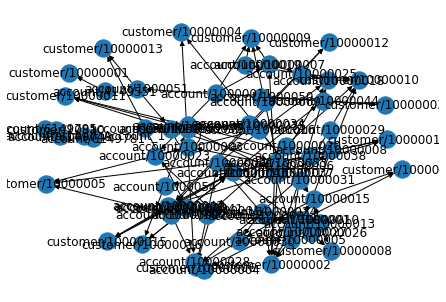

In [20]:
name = "fraud-detection"

# Start from ArangoDB graph
original_fraud_adb_g = db.graph(name) 

# Create NetworkX graph from ArangoDB graph
fraud_nx_g = adbnx_adapter.arangodb_graph_to_networkx(name)
nx.draw(fraud_nx_g, with_labels=True)

# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Heterogeneous, we must provide multiple edge definitions.
edge_definitions = [
    {
        "edge_collection": "accountHolder_new",
        "from_vertex_collections": ["customer_new"],
        "to_vertex_collections": ["account_new"],
    },
    {
        "edge_collection": "transaction_new",
        "from_vertex_collections": ["account_new"],
        "to_vertex_collections": ["account_new"],
    },
]

class Fraud_ADBNX_Controller(ADBNX_Controller):
  """ArangoDB-NetworkX controller.

  Responsible for controlling how nodes & edges are handled when
  transitioning from ArangoDB to NetworkX, and vice-versa.

  You can derive your own custom ADBNX_Controller, but it is not
  necessary for Homogeneous graphs.
  """
  # Since we are dealing with a Heterogeneous, we must implement _identify_networkx_node().
  def _identify_networkx_node(self, nx_node_id: NxId, nx_node: NxData) -> str:
    """Given a NetworkX node, identify what ArangoDB collection it should belong to.

    NOTE: You must override this function if your NetworkX graph is NOT Homogeneous
    or does NOT comply to ArangoDB standards (i.e the node IDs are not formatted
    like "{collection}/{key}").

    :param nx_node_id: The NetworkX ID of the node.
    :type nx_node_id: adbnx_adapter.typings.NxId
    :param nx_node: The NetworkX node object.
    :type nx_node: adbnx_adapter.typings.NxData
    :return: The ArangoDB collection name
    :rtype: str
    """
    adb_vertex_id: str = str(nx_node_id)
    return adb_vertex_id.split("/")[0] + "_new"

  # Since we are dealing with a Heterogeneous, we must implement _identify_networkx_edge().
  def _identify_networkx_edge(self, nx_edge: NxData, from_nx_node: NxData, to_nx_node: NxData) -> str:
    """Given a NetworkX edge, and its pair of nodes, identify what ArangoDB
    collection should it belong to.

    NOTE #1: You must override this function if your NetworkX graph is NOT Homogeneous
    or does NOT comply to ArangoDB standards
    (i.e the edge IDs are not formatted like "{collection}/{key}").

    NOTE #2: You can accesss the ID & Collection belonging to the
    **from_nx_node** & **to_nx_node** parameters via their "nx_id" & "col"
    attribute keys. E.g `from_collection = from_nx_node["col"]`

    :param nx_edge: The NetworkX edge object.
    :type nx_edge: adbnx_adapter.typings.NxData
    :param from_nx_node: The NetworkX node object representing the edge source.
    :type from_nx_node: adbnx_adapter.typings.NxData
    :param to_nx_node: The NetworkX node object representing the edge destination.
    :type to_nx_node: adbnx_adapter.typings.NxData
    :return: The ArangoDB collection name
    :rtype: str
    """
    adb_vertex_id: str = str(nx_edge["_id"])
    return adb_vertex_id.split("/")[0] + "_new"


fraud_adbnx_adapter = ADBNX_Adapter(con, Fraud_ADBNX_Controller())

# Create a new ArangoDB graph from NetworkX graph
new_name = name + "_new"
db.delete_graph(new_name, drop_collections=True, ignore_missing=True)
# Keify nodes & edges to keep the same key values as original (this is optional)
new_fraud_adb_g = fraud_adbnx_adapter.networkx_to_arangodb(
    new_name,
    fraud_nx_g,
    edge_definitions,
    keyify_nodes=True,
    keyify_edges=True,
)

print(f"Inspect the new graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{new_name}")
print(f"View the original graph here: https://tutorials.arangodb.cloud:8529/_db/{con['dbName']}/_admin/aardvark/index.html#graph/{name}")


## Example 3: NetworkX ➡ ArangoDB ➡ NetworkX

[((0, 0), {}), ((0, 1), {}), ((0, 2), {}), ((0, 3), {}), ((0, 4), {}), ((1, 0), {}), ((1, 1), {}), ((1, 2), {}), ((1, 3), {}), ((1, 4), {}), ((2, 0), {}), ((2, 1), {}), ((2, 2), {}), ((2, 3), {}), ((2, 4), {}), ((3, 0), {}), ((3, 1), {}), ((3, 2), {}), ((3, 3), {}), ((3, 4), {}), ((4, 0), {}), ((4, 1), {}), ((4, 2), {}), ((4, 3), {}), ((4, 4), {})]
[((0, 0), (1, 0), {}), ((0, 0), (0, 1), {}), ((0, 1), (1, 1), {}), ((0, 1), (0, 2), {}), ((0, 2), (1, 2), {}), ((0, 2), (0, 3), {}), ((0, 3), (1, 3), {}), ((0, 3), (0, 4), {}), ((0, 4), (1, 4), {}), ((1, 0), (2, 0), {}), ((1, 0), (1, 1), {}), ((1, 1), (2, 1), {}), ((1, 1), (1, 2), {}), ((1, 2), (2, 2), {}), ((1, 2), (1, 3), {}), ((1, 3), (2, 3), {}), ((1, 3), (1, 4), {}), ((1, 4), (2, 4), {}), ((2, 0), (3, 0), {}), ((2, 0), (2, 1), {}), ((2, 1), (3, 1), {}), ((2, 1), (2, 2), {}), ((2, 2), (3, 2), {}), ((2, 2), (2, 3), {}), ((2, 3), (3, 3), {}), ((2, 3), (2, 4), {}), ((2, 4), (3, 4), {}), ((3, 0), (4, 0), {}), ((3, 0), (3, 1), {}), ((3, 1), (

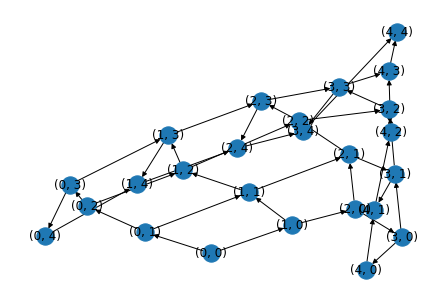

In [21]:
# Load the nx graph
original_grid_nx_g = nx.grid_2d_graph(5, 5)
print(original_grid_nx_g.nodes(data=True))
print(original_grid_nx_g.edges(data=True))

# We must provide edge definitions to create the ArangoDB graph
# Since this graph is Homogeneous, we only need one edge definition.
edge_definitions = [
    {
        "edge_collection": "to_v2",
        "from_vertex_collections": ["Grid_Node_v2"],
        "to_vertex_collections": ["Grid_Node_v2"],
    }
]

# Re-introduce the Grid controller class
class Grid_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.

    You can derive your own custom ADBNX_Controller, but it is not
    necessary for Homogeneous graphs.
    """
    def _prepare_arangodb_vertex(self, adb_vertex: Json, col: str) -> NxId:
        """Prepare an ArangoDB vertex before it gets inserted into the NetworkX
        graph.

        Given an ArangoDB vertex, you can modify it before it gets inserted
        into the NetworkX graph, and/or derive a custom node id for networkx to use.
        In most cases, it is only required to return the ArangoDB _id of the vertex.

        :param adb_vertex: The ArangoDB vertex object to (optionally) modify.
        :type adb_vertex: adbnx_adapter.typings.Json
        :param col: The ArangoDB collection the vertex belongs to.
        :type col: str
        :return: The ArangoDB _id attribute of the vertex.
        :rtype: str
        """
        nx_node_id = tuple(
            int(n)
            for n in tuple(
                adb_vertex["_key"],
            )
        )
        return nx_node_id

    def _keyify_networkx_node(self, nx_node_id: NxId, nx_node: NxData, col: str) -> str:
        """Given a NetworkX node, derive its valid ArangoDB key.

        NOTE: You must override this function if you want to create custom ArangoDB _key
        values for your NetworkX nodes or if your NetworkX graph does NOT comply to
        ArangoDB standards (i.e the node IDs are not formatted
        like "{collection}/{key}"). For more  info, see the **keyify_nodes**
        parameter of ADBNX_Adapter.networkx_to_arangodb()

        :param nx_node_id: The NetworkX node id.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param col: The ArangoDB collection the node belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        adb_v_key: str = self._tuple_to_arangodb_key_helper(nx_node_id)  # type: ignore
        return adb_v_key

# Re-instantiate the Grid adapter class
grid_adbnx_adapter = ADBNX_Adapter(con, Grid_ADBNX_Controller())

# Delete the Grid graph if it already exists in ArangoDB
name = "Grid_2"
db.delete_graph(name, drop_collections=True, ignore_missing=True)

# Create the ArangoDB graph
grid_adbnx_adapter.networkx_to_arangodb(name, original_grid_nx_g, edge_definitions, keyify_nodes=True)

# Create the NetworkX graph from the ArangoDB graph
new_grid_nx_g = grid_adbnx_adapter.arangodb_graph_to_networkx(name)

# Draw the new graph
nx.draw(new_grid_nx_g, with_labels=True)
print(new_grid_nx_g.nodes(data=True))
print(new_grid_nx_g.edges(data=True))